# Import Libraries

In [1]:
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import os
import json
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import pandas as pd

stops = set(stopwords.words("english"))

# Creating SR dataframe
Now we create dataframe for all the SRs by reading the data from the file, cleaning it, and then adding it into a pandas dataframe indexed by SR.

In [2]:
sr_df = pd.read_excel('SR_DNAC_Oct25_FieldList.xlsx', sheet_name = 'SR_DNAC_Oct25')
sr_df.head()




,incident_number,casenumber,incident_type,incident_status,comm_pref_code,complexity,current_severity,initial_severity,max_severity,bug_cnt,...,tss.incident_number,tss.problem_code,tss.resolution_code,tss.customer_activity_code,tss.case_impact_catg_code,tss.case_impact_status_code,tss.case_impact_user_cnt_code,tss.initial_problem_code,tss.underlying_cause_code,tss.underlying_cause
0,685375405,1121441655,TAC,Customer Updated,EMAIL,NaN,3,3,3,NaN,...,685375405,INSTLL_UNSTLL_UPGRD,SW_CONFIG,UPGRADE,NOT AVAILABLE,NOT AVAILABLE,NOT AVAILABLE,INSTLL_UNSTLL_UPGRD,COMM003,Software Bug
1,685375255,1121441441,TAC,Customer Pending,EMAIL,NaN,3,3,3,NaN,...,685375255,INSTLL_UNSTLL_UPGRD,RESOLV_BY_CUST,UPGRADE,NOT AVAILABLE,NOT AVAILABLE,NOT AVAILABLE,INSTLL_UNSTLL_UPGRD,COMM004,"Software -not a bug (scalability, version sele..."
2,685375176,1121441341,TAC,Customer Updated,EMAIL,NaN,3,3,3,NaN,...,685375176,CONFIG_ASSISTANCE,CUSTOMER_EDUCATION,CONFIG,NOT AVAILABLE,NOT AVAILABLE,NOT AVAILABLE,CONFIG_ASSISTANCE,COMM007,Configuration Assistance (process not intuitiv...
3,685375012,1121441096,TAC,DE Pending Workaround,EMAIL,NaN,3,3,3,NaN,...,685375012,SOFTWARE_FAILURE,NOT AVAILABLE,OPERATE,NOT AVAILABLE,NOT AVAILABLE,NOT AVAILABLE,SOFTWARE_FAILURE,NaN,NaN
4,685374397,1121440168,TAC,Customer Updated,EMAIL,NaN,3,3,3,NaN,...,685374397,INSTLL_UNSTLL_UPGRD,NOT AVAILABLE,INSTALL,NOT AVAILABLE,NOT AVAILABLE,NOT AVAILABLE,INSTLL_UNSTLL_UPGRD,NaN,NaN


In [3]:
sr_df = sr_df.fillna(value="NULL")

# Encoding data as one hot labels

In [4]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

Y = sr_df['tss.customer_activity_code']
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
dummy_y = np_utils.to_categorical(encoded_Y)
print(dummy_y)
sr_df = sr_df.drop(columns=['tss.customer_activity_code'])

/apps/dslab/anaconda/python3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


[[0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0.]
 ...
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]]


CONFIG      1262
OPERATE      774
INSTALL      531
UPGRADE      283
NULL          39
PLANNING       2
Name: tss.customer_activity_code, dtype: int64


Text(0,0.5,'Number of SRs')

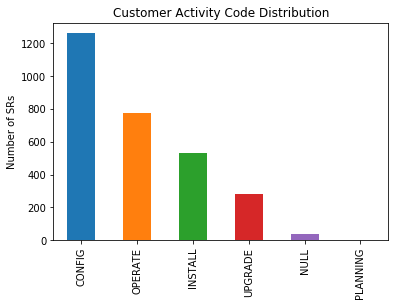

In [5]:
frequency_count = Y.value_counts()
print(frequency_count)
ax_1 = frequency_count.plot(kind='bar', title='Customer Activity Code Distribution')
ax_1.set_ylabel('Number of SRs')

# Train Test Split

In [6]:
from sklearn.cross_validation import train_test_split
seed=20
sr_df = sr_df[['tss.problem_code', 'tss.resolution_code', 'tss.underlying_cause_code', 'summary']]
X_train, X_test, Y_train, Y_test = train_test_split(sr_df, dummy_y, test_size=0.15, random_state=seed, stratify=Y) 


/apps/dslab/anaconda/python3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Embedding categorical variables

In [7]:
from sklearn.preprocessing import LabelEncoder

X_train_categorical = X_train[['tss.problem_code', 'tss.resolution_code', 'tss.underlying_cause_code']].apply(LabelEncoder().fit_transform)
X_test_categorical = X_test[['tss.problem_code', 'tss.resolution_code', 'tss.underlying_cause_code']].apply(LabelEncoder().fit_transform)
X_train_text = X_train['summary']
X_test_text = X_test['summary']

# More import libraries

In [8]:
from keras.layers import Input, Embedding, Dense, Flatten, Dropout, concatenate
from keras.layers import BatchNormalization, SpatialDropout1D
from keras.callbacks import Callback
from keras.models import Model
from keras.optimizers import Adam

# Embedding categorical values

In [9]:
import numpy as np
max_prob_code = np.max([X_train_categorical['tss.problem_code'].max(), X_test_categorical['tss.problem_code'].max()])+1
max_res_code = np.max([X_train_categorical['tss.resolution_code'].max(), X_test_categorical['tss.resolution_code'].max()])+1
max_cause_code = np.max([X_train_categorical['tss.underlying_cause_code'].max(), X_test_categorical['tss.underlying_cause_code'].max()])+1

## Creating embeddings using keras

In [10]:
import tensorflow as tf
from tensorflow.keras.layers import Reshape

emb_n = 10
dense_n = 500
in_pc = Input(shape=[1], name = 'prob_code')
emb_pc = Embedding(max_prob_code, emb_n)(in_pc)
# reshaped_pc = tf.reshape(emb_pc, shape=[tf.shape(emb_pc)[0], 10], name='reshaped_emb_pc')
in_rc = Input(shape=[1], name = 'res_code')
emb_rc = Embedding(max_res_code, emb_n)(in_rc)
# reshaped_rc = tf.reshape(emb_rc, shape=[tf.shape(emb_rc)[0], 10], name='reshaped_emb_rc')
in_cc = Input(shape=[1], name = 'cause_code')
emb_cc = Embedding(max_cause_code, emb_n)(in_cc)
# reshaped_cc = tf.reshape(emb_cc, shape=[tf.shape(emb_cc)[0], 10], name='reshaped_emb_cc')

# Embedding text values using BERT

In [11]:
from bert_serving.client import BertClient
bc = BertClient()
X_train_bert = bc.encode(list(X_train_text))
X_test_bert = bc.encode(list(X_test_text))


# Perform PCA on the embedding to reduce dimension

In [12]:
from sklearn.decomposition import PCA
from matplotlib import pyplot
pca = PCA(n_components=10)
X_train_bert = pca.fit_transform(X_train_bert)
X_test_bert = pca.fit_transform(X_test_bert)

In [13]:
from tensorflow.keras.layers import Reshape
in_bert = Input(shape=[10], name = 'bert_summary')
bert = Dense(10, activation="relu")(in_bert)

# Concatenate to form single network

In [25]:

fe = concatenate([(emb_pc), (emb_rc), (emb_cc)])
s_dout = SpatialDropout1D(0.2)(fe)
x = Flatten()(s_dout)
x = concatenate([(x), (bert)])
x = Dropout(0.2)(Dense(dense_n,activation='relu')(fe))
x = Dropout(0.2)(Dense(dense_n,activation='relu')(x))
outp = Dense(6,activation='softmax')(x)
outp_flattened = Flatten()(outp)

model = Model(inputs=[in_pc, in_rc, in_cc, in_bert], outputs=outp_flattened)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
prob_code (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
res_code (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
cause_code (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 10)        120         prob_code[0][0]                  
__________________________________________________________________________________________________
embedding_

In [15]:
import numpy as np
def get_keras_data(dataset_categorical, dataset_bert):
    X = {
        'prob_code': np.array(dataset_categorical['tss.problem_code']),
        'res_code': np.array(dataset_categorical['tss.resolution_code']),
        'cause_code': np.array(dataset_categorical['tss.underlying_cause_code']),
        'bert_summary': np.array(dataset_bert)
    }
    return X
X_train = get_keras_data(X_train_categorical, X_train_bert)
X_test = get_keras_data(X_test_categorical, X_test_bert)

In [16]:
import tensorflow as tf
import keras.backend as K

def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    # tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

# Train the model

In [26]:
from keras.callbacks import ModelCheckpoint

batch_size = 128
epochs = 100
exp_decay = lambda init, fin, steps: (init/fin)**(1/(steps-1)) - 1
steps = int(len(X_train) / batch_size) * epochs
lr_init, lr_fin = 0.001, 0.0001
lr_decay = exp_decay(lr_init, lr_fin, steps)
optimizer_adam = Adam(lr=0.001, decay=lr_decay)
model.compile(loss='categorical_crossentropy',optimizer=optimizer_adam,metrics=[f1])
filepath="weights-improvement-{epoch:02d}-{val_f1:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_f1', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]


model.fit(X_train, Y_train, validation_split=0.15, epochs = epochs, shuffle=True, batch_size=batch_size, callbacks=callbacks_list)

Train on 2088 samples, validate on 369 samples
Epoch 1/100
2088/2088 [==============================] - 1s 253us/step - loss: 1.4701 - f1: 0.0275 - val_loss: 1.1280 - val_f1: 0.1079

Epoch 00001: val_f1 improved from -inf to 0.10792, saving model to weights-improvement-01-0.11.hdf5
Epoch 2/100
2088/2088 [==============================] - 0s 46us/step - loss: 1.0885 - f1: 0.1733 - val_loss: 1.0069 - val_f1: 0.1980

Epoch 00002: val_f1 improved from 0.10792 to 0.19802, saving model to weights-improvement-02-0.20.hdf5
Epoch 3/100
2088/2088 [==============================] - 0s 45us/step - loss: 1.0127 - f1: 0.2251 - val_loss: 0.9885 - val_f1: 0.2392

Epoch 00003: val_f1 improved from 0.19802 to 0.23915, saving model to weights-improvement-03-0.24.hdf5
Epoch 4/100
2088/2088 [==============================] - 0s 45us/step - loss: 0.9800 - f1: 0.2844 - val_loss: 0.9889 - val_f1: 0.2722

Epoch 00004: val_f1 improved from 0.23915 to 0.27221, saving model to weights-improvement-04-0.27.hdf5
Epo


Epoch 00040: val_f1 did not improve from 0.40729
Epoch 41/100
2088/2088 [==============================] - 0s 44us/step - loss: 0.8434 - f1: 0.4542 - val_loss: 1.0722 - val_f1: 0.3760

Epoch 00041: val_f1 did not improve from 0.40729
Epoch 42/100
2088/2088 [==============================] - 0s 44us/step - loss: 0.8324 - f1: 0.4516 - val_loss: 1.0780 - val_f1: 0.3830

Epoch 00042: val_f1 did not improve from 0.40729
Epoch 43/100
2088/2088 [==============================] - 0s 43us/step - loss: 0.8414 - f1: 0.4426 - val_loss: 1.0594 - val_f1: 0.3812

Epoch 00043: val_f1 did not improve from 0.40729
Epoch 44/100
2088/2088 [==============================] - 0s 44us/step - loss: 0.8343 - f1: 0.4266 - val_loss: 1.0763 - val_f1: 0.3863

Epoch 00044: val_f1 did not improve from 0.40729
Epoch 45/100
2088/2088 [==============================] - 0s 44us/step - loss: 0.8326 - f1: 0.4634 - val_loss: 1.1027 - val_f1: 0.3554

Epoch 00045: val_f1 did not improve from 0.40729
Epoch 46/100
2088/2088 [=


Epoch 00084: val_f1 did not improve from 0.42256
Epoch 85/100
2088/2088 [==============================] - 0s 44us/step - loss: 0.7948 - f1: 0.4637 - val_loss: 1.1562 - val_f1: 0.3977

Epoch 00085: val_f1 did not improve from 0.42256
Epoch 86/100
2088/2088 [==============================] - 0s 43us/step - loss: 0.7904 - f1: 0.4948 - val_loss: 1.1473 - val_f1: 0.3793

Epoch 00086: val_f1 did not improve from 0.42256
Epoch 87/100
2088/2088 [==============================] - 0s 44us/step - loss: 0.7897 - f1: 0.4627 - val_loss: 1.1648 - val_f1: 0.3979

Epoch 00087: val_f1 did not improve from 0.42256
Epoch 88/100
2088/2088 [==============================] - 0s 46us/step - loss: 0.7876 - f1: 0.4721 - val_loss: 1.1839 - val_f1: 0.3909

Epoch 00088: val_f1 did not improve from 0.42256
Epoch 89/100
2088/2088 [==============================] - 0s 45us/step - loss: 0.7851 - f1: 0.4924 - val_loss: 1.1672 - val_f1: 0.3619

Epoch 00089: val_f1 did not improve from 0.42256
Epoch 90/100
2088/2088 [=

# Test the model

In [27]:
results = model.evaluate(x=X_test, y=Y_test)

434/434 [==============================] - 0s 33us/step


In [28]:
metrics = model.metrics_names
results_dict = dict(zip(metrics, results))
print("Results:", results_dict)

Results: {'loss': 2.1057283823391257, 'f1': 0.2509911620671848}


# Perform prediction

In [29]:
def test_predict(model, x):
    yhat_prob = model.predict(x)
    yhat=[]
    for i in range(yhat_prob.shape[0]):
        datum = yhat_prob[i]
        decoded_datum = np.argmax(yhat_prob[i])
        yhat.append(decoded_datum)
    return yhat

In [30]:
yhat = model.predict(X_test)


# Test model accuracy

In [31]:
import numpy as np
predicted_outputs = np.argmax(yhat, axis=1)
actual_outputs = np.argmax(Y_test, axis=1)
print("Predicted Output:", predicted_outputs)
print("Actual Output:", actual_outputs)
print("Accuracy:", (predicted_outputs == actual_outputs).sum()/len(actual_outputs))

Predicted Output: [0 0 0 0 0 0 0 3 0 0 0 0 0 5 0 0 1 0 1 0 3 0 0 1 0 0 0 1 0 0 0 3 0 0 0 3 0
 0 0 0 1 3 0 0 3 0 3 0 0 1 0 3 0 1 0 0 0 0 0 0 0 0 0 0 1 3 1 1 0 0 0 0 0 3
 1 1 1 0 0 0 1 3 0 0 0 0 0 3 0 0 0 0 0 0 1 3 0 0 0 0 0 0 3 1 3 0 3 1 0 0 0
 5 3 0 1 3 0 3 5 0 3 3 0 5 0 1 3 5 0 3 1 0 0 0 0 3 1 0 0 0 3 0 1 0 1 0 0 3
 0 0 1 1 1 3 0 0 1 3 0 0 0 0 0 5 0 0 1 5 0 3 3 0 1 0 3 3 1 0 0 0 0 0 0 1 0
 5 0 0 0 0 0 0 0 0 0 0 3 0 0 0 3 1 0 0 3 0 3 0 0 0 0 0 0 1 0 0 0 0 0 1 3 0
 1 1 0 0 0 1 1 5 1 1 0 0 3 3 1 0 3 1 1 0 0 0 3 0 0 0 1 0 0 0 1 0 0 3 0 0 0
 0 0 0 1 0 0 0 0 5 3 0 0 5 0 0 0 0 0 0 0 0 0 0 1 5 0 0 0 5 5 0 0 0 0 0 0 0
 0 1 0 0 0 1 0 0 0 0 0 5 1 0 0 0 0 0 3 0 1 3 0 3 0 0 0 0 0 0 0 0 0 0 0 1 0
 3 0 3 0 1 0 0 0 0 0 3 3 0 0 5 1 1 0 1 3 0 1 0 0 1 0 3 3 0 3 0 0 3 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 3 3 0 0 3 0 0 0 0 1 0 0 0 0 0 1 0 1 0
 0 0 0 3 1 0 0 3 3 0 1 0 0 3 0 0 0 3 3 0 3 0 0 0 0 0 5]
Actual Output: [3 0 0 0 0 0 5 3 1 0 0 0 0 1 3 0 1 0 1 0 3 3 0 5 0 0 0 5 5 1 1 0 3 0 0 3 0
 1 3 0 1 0 

# Test top n accuracy

In [32]:
def compare_top_n(predicted, actual):
    total_obs = float(len(actual))
    matches = 0
    for i, each_predicted in enumerate(predicted):
        top_n = each_predicted.argsort()[-3:][::-1]
        if actual[i] in top_n:
            matches += 1
    return matches/total_obs

In [33]:
compare_top_n(yhat, actual_outputs)

0.9170506912442397